In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import random
import html
from tqdm import tqdm

# Read & split data

In [2]:
def preprocess_text(text):
    # Decode HTML (&quot; -> ", &amp; -> &; ...)
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def read_pair_files(src_file_path, trg_file_path):
    print(f"Reading and Preprocessing data from: {src_file_path} and {trg_file_path}...")

    with open(src_file_path, 'r', encoding='utf-8') as f:
        src_lines = f.read().strip().split('\n')

    with open(trg_file_path, 'r', encoding='utf-8') as f:
        trg_lines = f.read().strip().split('\n')

    assert len(src_lines) == len(trg_lines), "Error: Rows of source and target are different"

    dataset = []
    
    for src, trg in tqdm(zip(src_lines, trg_lines), total=len(src_lines)):
        src_clean = preprocess_text(src)
        trg_clean = preprocess_text(trg)
        
        if len(src_clean) > 0 and len(trg_clean) > 0:
            dataset.append({'src': src_clean, 'trg': trg_clean})

    print(f"Done! Cleaned and read: {len(dataset)} rows.")
    return dataset

In [3]:
train_src_file = "/kaggle/input/iwslt-15-en-vi/train.en.txt"
train_trg_file = "/kaggle/input/iwslt-15-en-vi/train.vi.txt"
test_src_file = "/kaggle/input/iwslt-15-en-vi/tst2013.en.txt"
test_trg_file = "/kaggle/input/iwslt-15-en-vi/tst2013.vi.txt"

full_train_data = read_pair_files(train_src_file, train_trg_file)
test_data = read_pair_files(test_src_file, test_trg_file)

Reading and Preprocessing data from: /kaggle/input/iwslt-15-en-vi/train.en.txt and /kaggle/input/iwslt-15-en-vi/train.vi.txt...


100%|██████████| 133317/133317 [00:02<00:00, 51579.66it/s]


Done! Cleaned and read: 133166 rows.
Reading and Preprocessing data from: /kaggle/input/iwslt-15-en-vi/tst2013.en.txt and /kaggle/input/iwslt-15-en-vi/tst2013.vi.txt...


100%|██████████| 1268/1268 [00:00<00:00, 51951.49it/s]

Done! Cleaned and read: 1268 rows.


In [4]:
random.shuffle(full_train_data)
split_ratio = 0.9
split_idx = int(len(full_train_data) * split_ratio)

train_data = full_train_data[:split_idx]
valid_data = full_train_data[split_idx:]

print(f"Data split: Train={len(train_data)}, Valid={len(valid_data)}, Test={len(test_data)}")

Data split: Train=119849, Valid=13317, Test=1268


# Vocabulary & dataloader

In [5]:
class Vocabulary:
    def __init__(self):
        self.stoi = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.itos = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
        self.freq_threshold = 2

    def tokenizer(self, text):
        text = text.lower().strip()
        return re.findall(r"\w+|[^\w\s]", text)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [self.stoi.get(token, self.stoi['<unk>']) for token in tokenized_text]

In [6]:
print("Building vocabulary...")
src_vocab = Vocabulary()
trg_vocab = Vocabulary()

src_texts = [item['src'] for item in train_data]
trg_texts = [item['trg'] for item in train_data]

src_vocab.build_vocabulary(src_texts)
trg_vocab.build_vocabulary(trg_texts)

print(f"Vocab Size -> En: {len(src_vocab.stoi)}, Vi: {len(trg_vocab.stoi)}")

Building vocabulary...
Vocab Size -> En: 26690, Vi: 11278


In [7]:
class ManualDataset(Dataset):
    def __init__(self, data, src_vocab, trg_vocab):
        self.data = data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        pair = self.data[index]
        src_text = pair['src']
        trg_text = pair['trg']

        # [SOS] + [Indices] + [EOS]
        src_indices = [1] + self.src_vocab.numericalize(src_text) + [2]
        trg_indices = [1] + self.trg_vocab.numericalize(trg_text) + [2]

        return torch.tensor(src_indices), torch.tensor(trg_indices)

class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        src_batch, trg_batch = zip(*batch)
        # Dynamic batch padding, only pad to size of the largest in batch
        src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=self.pad_idx, batch_first=True)
        trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=self.pad_idx, batch_first=True)
        return src_batch, trg_batch

# Transformer Architechture

In [8]:
import torch
import torch.nn as nn
import math

class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len=5000, drop_prob=0.1):
        super().__init__()
        self.d_model = d_model

        # Input/Output Embedding
        self.tok_emb = nn.Embedding(vocab_size, d_model)

        # Positional Encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Sin PE
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0)) # no update gradient
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # x: (Batch, Seq_Len)
        token_emb = self.tok_emb(x) * math.sqrt(self.d_model)
        # 2. Add PE
        pos_emb = self.pe[:, :x.size(1), :]
        return self.dropout(token_emb + pos_emb)

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.head_dim = d_model // n_head
        self.d_model = d_model

        # Q, K, V
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        # Linear
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # q, k, v: (Batch, Seq_Len, d_model)
        batch_size = q.size(0)

        # 1. Linear Project & Split Heads
        # d_model -> n_head x head_dim
        Q = self.w_q(q).view(batch_size, -1, self.n_head, self.head_dim).permute(0, 2, 1, 3)
        K = self.w_k(k).view(batch_size, -1, self.n_head, self.head_dim).permute(0, 2, 1, 3)
        V = self.w_v(v).view(batch_size, -1, self.n_head, self.head_dim).permute(0, 2, 1, 3)

        # 2. Scaled Dot-Product Attention
        # Energy: Q * K^T / sqrt(head_dim)
        energy = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # 3. Apply Mask
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e9)

        # 4. Softmax & Weighted Sum
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(attention, V) # (Batch, n_head, Seq_Len, head_dim)

        # 5. Concat Heads & Final Linear
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.fc_out(x)

In [10]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        # Linear -> ReLU -> Linear
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super().__init__()
        # Sub-layer 1: Self Attention
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = nn.LayerNorm(d_model) # Add & Norm

        # Sub-layer 2: Feed Forward
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model) # Add & Norm

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # 1. Self-Attention: Multi-Head attention with all Q,K,V from src
        _src = self.self_attn(src, src, src, src_mask)

        # Add & Norm (Residual)
        src = self.norm1(src + self.dropout(_src))

        # 2. Feed Forward
        _src = self.ffn(src)

        # Add & Norm
        src = self.norm2(src + self.dropout(_src))
        return src

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super().__init__()

        # Sub-layer 1: Masked Self-Attention
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = nn.LayerNorm(d_model)

        # Sub-layer 2: Cross-Attention
        self.cross_attn = MultiHeadAttention(d_model, n_head)
        self.norm2 = nn.LayerNorm(d_model)

        # Sub-layer 3: Feed Forward
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # 1. Masked Self-Attention
        # Q, K, V from src. Mask: future mask
        _trg = self.self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))

        # 2. Cross-Attention (Encoder-Decoder Attention)
        # Q: target (Decoder), K,V: source (Encoder)
        _trg = self.cross_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))

        # 3. Feed Forward
        _trg = self.ffn(trg)
        trg = self.norm3(trg + self.dropout(_trg))

        return trg

In [13]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size, trg_vocab_size,
        src_pad_idx, trg_pad_idx,
        d_model=512, n_head=8, n_layer=6, d_ff=2048,
        dropout=0.1, device="cuda"
    ):
        super().__init__()
        self.device = device
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        # 1. Input Embeddings & Positional Encoding
        self.src_embedding = TransformerEmbedding(src_vocab_size, d_model, drop_prob=dropout)
        self.trg_embedding = TransformerEmbedding(trg_vocab_size, d_model, drop_prob=dropout)

        # 2. Encoder (Nx)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)
        ])

        # 3. Decoder (Nx)
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)
        ])

        # 4. Linear & Softmax
        # PyTorch CrossEntropyLoss included Softmax
        self.fc_out = nn.Linear(d_model, trg_vocab_size)

    def make_src_mask(self, src):
        # padding mask
        # Shape: (Batch, 1, 1, Src_Len)
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)

    def make_trg_mask(self, trg):
        # padding mask
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # future mask
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        return (trg_pad_mask & trg_sub_mask).to(self.device)

    def forward(self, src, trg):
        # src: (Batch, Src_Len) -> Inputs
        # trg: (Batch, Trg_Len) -> Outputs (shifted right)

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # --- Encoder Flow ---
        # 1. Input -> Embedding + Positional Encoding
        enc_src = self.src_embedding(src)

        # 2. Nx Encoder
        for layer in self.encoder_layers:
            enc_src = layer(enc_src, src_mask)

        # --- Decoder Flow ---
        # 3. Output (shifted) -> Embedding + Positional Encoding
        output = self.trg_embedding(trg)

        # 4. Nx Decoder
        for layer in self.decoder_layers:
            output = layer(output, enc_src, trg_mask, src_mask)

        # 5. Output Probabilities
        return self.fc_out(output)

# MT Transformer Training

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import re
from collections import Counter
import math
import time

In [15]:
# --- Hyperparameters ---
BATCH_SIZE = 16
D_MODEL = 256   # 512
N_HEAD = 4      # 8
N_LAYER = 4     # 6
D_FF = 1024     # 2048
DROPOUT = 0.1
EPOCHS = 10
LEARNING_RATE = 0.0001
MAX_LEN = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [16]:
# --- Model ---
model = Transformer(
    src_vocab_size=len(src_vocab.stoi),
    trg_vocab_size=len(trg_vocab.stoi),
    src_pad_idx=0,
    trg_pad_idx=0,
    d_model=D_MODEL,
    n_head=N_HEAD,
    n_layer=N_LAYER,
    d_ff=D_FF,
    dropout=DROPOUT,
    device=DEVICE
).to(DEVICE)

# --- Weights ---
# Xavier Initialization
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights)

# --- Optimizer & Scheduler ---
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

# Loss Function
# ignore_index=0 ignore loss <pad> token
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [17]:
def train_epoch(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in tqdm(enumerate(iterator), total=len(iterator)):
        src, trg = src.to(DEVICE), trg.to(DEVICE)

        optimizer.zero_grad()

        # trg input: ignore <eos>
        # trg output ignore <sos>
        output = model(src, trg[:, :-1]) # (Batch, Seq_Len-1, Vocab_Size)

        output_dim = output.shape[-1]

        # Flatten for calc Loss
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            output = model(src, trg[:, :-1])

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# --- Inference ---
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()

    tokens = src_vocab.tokenizer(sentence)
    src_indexes = [src_vocab.stoi['<sos>']] + \
                  [src_vocab.stoi.get(token, src_vocab.stoi['<unk>']) for token in tokens] + \
                  [src_vocab.stoi['<eos>']]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.src_embedding(src_tensor)
        for layer in model.encoder_layers:
            enc_src = layer(enc_src, src_mask)

        trg_indexes = [trg_vocab.stoi['<sos>']]

        for i in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)

            output = model.trg_embedding(trg_tensor)
            for layer in model.decoder_layers:
                output = layer(output, enc_src, trg_mask, src_mask)

            output = model.fc_out(output)
            pred_token = output.argmax(2)[:,-1].item()

            trg_indexes.append(pred_token)
            if pred_token == trg_vocab.stoi['<eos>']:
                break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:-1] # ignore sos, eos

In [18]:
import matplotlib.pyplot as plt

In [19]:
train_ds = ManualDataset(train_data, src_vocab, trg_vocab)
valid_ds = ManualDataset(valid_data, src_vocab, trg_vocab)
test_ds  = ManualDataset(test_data, src_vocab, trg_vocab)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(pad_idx=0))
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx=0))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx=0))

In [20]:
# --- MAIN LOOP ---
CLIP = 1
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_ppls = []
valid_ppls = []

print(f"Start Training on {DEVICE}...")

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_ppls.append(math.exp(train_loss))
    valid_ppls.append(math.exp(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-model.pt')
        print(f"Saved Model (Val Loss: {valid_loss:.3f})")

    print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Start Training on cuda...


100%|██████████| 7491/7491 [04:05<00:00, 30.53it/s]


Saved Model (Val Loss: 4.249)
Epoch: 01 | Time: 4m 14s
	Train Loss: 4.980 | Train PPL: 145.523
	 Val. Loss: 4.249 |  Val. PPL:  70.017


100%|██████████| 7491/7491 [04:03<00:00, 30.75it/s]


Saved Model (Val Loss: 3.488)
Epoch: 02 | Time: 4m 12s
	Train Loss: 3.950 | Train PPL:  51.945
	 Val. Loss: 3.488 |  Val. PPL:  32.704


100%|██████████| 7491/7491 [04:04<00:00, 30.61it/s]


Saved Model (Val Loss: 3.042)
Epoch: 03 | Time: 4m 13s
	Train Loss: 3.388 | Train PPL:  29.595
	 Val. Loss: 3.042 |  Val. PPL:  20.943


100%|██████████| 7491/7491 [04:05<00:00, 30.46it/s]


Saved Model (Val Loss: 2.745)
Epoch: 04 | Time: 4m 14s
	Train Loss: 3.012 | Train PPL:  20.329
	 Val. Loss: 2.745 |  Val. PPL:  15.560


100%|██████████| 7491/7491 [04:04<00:00, 30.60it/s]


Saved Model (Val Loss: 2.573)
Epoch: 05 | Time: 4m 13s
	Train Loss: 2.759 | Train PPL:  15.787
	 Val. Loss: 2.573 |  Val. PPL:  13.110


100%|██████████| 7491/7491 [04:05<00:00, 30.58it/s]


Saved Model (Val Loss: 2.467)
Epoch: 06 | Time: 4m 13s
	Train Loss: 2.583 | Train PPL:  13.242
	 Val. Loss: 2.467 |  Val. PPL:  11.784


100%|██████████| 7491/7491 [04:04<00:00, 30.60it/s]


Saved Model (Val Loss: 2.386)
Epoch: 07 | Time: 4m 13s
	Train Loss: 2.456 | Train PPL:  11.660
	 Val. Loss: 2.386 |  Val. PPL:  10.874


100%|██████████| 7491/7491 [04:05<00:00, 30.52it/s]


Saved Model (Val Loss: 2.330)
Epoch: 08 | Time: 4m 14s
	Train Loss: 2.356 | Train PPL:  10.553
	 Val. Loss: 2.330 |  Val. PPL:  10.280


100%|██████████| 7491/7491 [04:06<00:00, 30.44it/s]


Saved Model (Val Loss: 2.299)
Epoch: 09 | Time: 4m 14s
	Train Loss: 2.283 | Train PPL:   9.810
	 Val. Loss: 2.299 |  Val. PPL:   9.960


100%|██████████| 7491/7491 [04:04<00:00, 30.61it/s]


Saved Model (Val Loss: 2.258)
Epoch: 10 | Time: 4m 13s
	Train Loss: 2.221 | Train PPL:   9.214
	 Val. Loss: 2.258 |  Val. PPL:   9.562


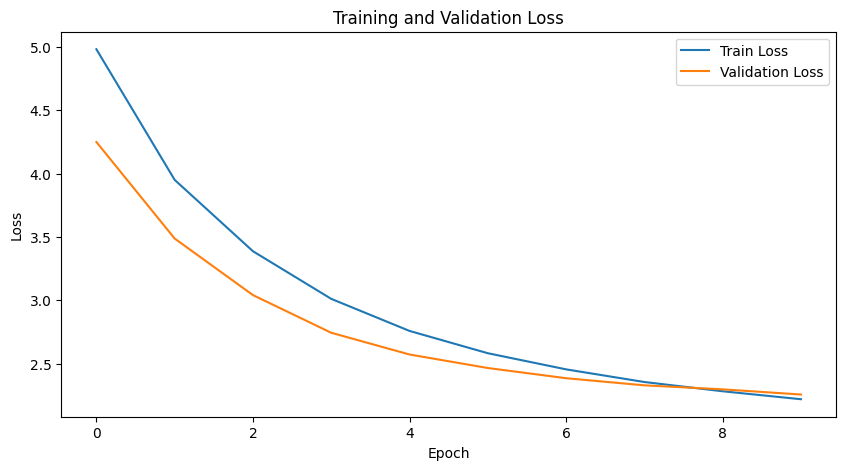

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:
print("\n--- Testing Translation ---")
sample_sentence = "hello world"
translation = translate_sentence(sample_sentence, src_vocab, trg_vocab, model, DEVICE)
print(f"Input: {sample_sentence}")
print(f"Output: {' '.join(translation)}")


--- Testing Translation ---
Input: hello world
Output: xin chào thế giới .


In [23]:
print("\n--- Testing Translation ---")
sample_sentence = "Attention is all you need"
translation = translate_sentence(sample_sentence, src_vocab, trg_vocab, model, DEVICE)
print(f"Input: {sample_sentence}")
print(f"Output: {' '.join(translation)}")


--- Testing Translation ---
Input: Attention is all you need
Output: sự chú ý là tất cả các bạn cần .


# Eval

In [24]:
import torch
from nltk.translate.bleu_score import corpus_bleu

In [25]:
model.load_state_dict(torch.load('transformer-model.pt', map_location=DEVICE))
model.eval()
print("Model loaded")

Model loaded


In [26]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()

    if isinstance(sentence, str):
        tokens = src_vocab.tokenizer(sentence)
    else:
        tokens = sentence

    src_indexes = [src_vocab.stoi['<sos>']] + \
                  [src_vocab.stoi.get(token, src_vocab.stoi['<unk>']) for token in tokens] + \
                  [src_vocab.stoi['<eos>']]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.src_embedding(src_tensor)
        for layer in model.encoder_layers:
            enc_src = layer(enc_src, src_mask)

        # Decoding
        trg_indexes = [trg_vocab.stoi['<sos>']]

        for i in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)

            output = model.trg_embedding(trg_tensor)
            for layer in model.decoder_layers:
                output = layer(output, enc_src, trg_mask, src_mask)

            # Predict
            output = model.fc_out(output)
            pred_token = output.argmax(2)[:,-1].item()

            trg_indexes.append(pred_token)

            # <eos>
            if pred_token == trg_vocab.stoi['<eos>']:
                break

    # Index to string
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]

    # remove <sos> và <eos>
    return trg_tokens[1:-1]

In [27]:
def calculate_bleu(data, src_vocab, trg_vocab, model, device):
    trgs = []
    pred_trgs = []

    print(f"BLEU in {len(data)} test rows")

    for i, example in enumerate(data):
        src = example['src']
        trg = example['trg']

        pred_trg = translate_sentence(src, src_vocab, trg_vocab, model, device)

        if isinstance(trg, str):
            trg_tokenized = trg_vocab.tokenizer(trg)
        else:
            trg_tokenized = trg

        pred_trgs.append(pred_trg)
        trgs.append([trg_tokenized]) # Fix: BLEU need list of lists for references

        if i % 500 == 0:
            print(f"--- Sentence: {i} ---")
            print(f"Src : {src}")
            print(f"Trg : {trg}")
            print(f"Pred: {' '.join(pred_trg)}")

    score = corpus_bleu(trgs, pred_trgs)
    return score

In [28]:
bleu_score = calculate_bleu(test_data, src_vocab, trg_vocab, model, DEVICE)
print(f'\nBLEU score = {bleu_score*100:.2f}')

BLEU in 1268 test rows
--- Sentence: 0 ---
Src : when i was little , i thought my country was the best on the planet , and i grew up singing a song called " nothing to envy . "
Trg : khi tôi còn nhỏ , tôi nghĩ rằng bắctriều tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài " chúng ta chẳng có gì phải ghen tị . "
Pred: khi tôi còn nhỏ , tôi nghĩ đất nước tôi là người tốt nhất trên hành tinh , và tôi lớn lên hát một bài hát gọi là " không có gì để làm phiền . "
--- Sentence: 500 ---
Src : back then , we had no idea how much this trip would change our lives .
Trg : hồi đó , chúng tôi không hề biết chuyến đi ấy sẽ thay đổi cuộc sống của chúng tôi như thế nào .
Pred: quay lại , chúng tôi không biết chuyến đi này sẽ thay đổi cuộc sống của chúng tôi bao nhiêu .
--- Sentence: 1000 ---
Src : so planning has this blind spot .
Trg : vậy nên hoạch định có một điểm mù này .
Pred: vì vậy , kế hoạch đã có một điểm mù .

BLEU score = 24.61


# Optim 1: Beam Search

In [29]:
import torch
import math

In [30]:
def translate_sentence_beam(sentence, src_vocab, trg_vocab, model, device, max_len=50, beam_size=3, alpha=0.7):
    model.eval()

    if isinstance(sentence, str):
        tokens = src_vocab.tokenizer(sentence)
    else:
        tokens = sentence

    src_indexes = [src_vocab.stoi['<sos>']] + \
                  [src_vocab.stoi.get(token, src_vocab.stoi['<unk>']) for token in tokens] + \
                  [src_vocab.stoi['<eos>']]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device) # (1, Src_Len)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.src_embedding(src_tensor)
        for layer in model.encoder_layers:
            enc_src = layer(enc_src, src_mask)

    sos_idx = trg_vocab.stoi['<sos>']
    eos_idx = trg_vocab.stoi['<eos>']

    beam = [([sos_idx], 0.0)]

    for _ in range(max_len):
        candidates = []
        for seq, score in beam:
            if seq[-1] == eos_idx:
                norm_score = score / (len(seq) ** alpha)
                candidates.append((seq, norm_score, True))
                continue

            trg_tensor = torch.LongTensor(seq).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)

            # Decoder
            with torch.no_grad():
                output = model.trg_embedding(trg_tensor)
                for layer in model.decoder_layers:
                    output = layer(output, enc_src, trg_mask, src_mask)

                output = model.fc_out(output)
                # shape: (1, 1, Vocab_Size) -> (Vocab_Size)
                log_probs = torch.log_softmax(output[:, -1, :], dim=-1).squeeze()

            topk_probs, topk_idxs = torch.topk(log_probs, beam_size)

            for k in range(beam_size):
                idx = topk_idxs[k].item()
                prob = topk_probs[k].item()
                new_seq = seq + [idx]
                new_score = score + prob # log_prob: log(a*b) = log(a) + log(b)
                candidates.append((new_seq, new_score, False))

        ordered = sorted(candidates, key=lambda x: x[1] / (len(x[0])**alpha) if not x[2] else x[1], reverse=True)
        beam = [(seq, score) for seq, score, _ in ordered[:beam_size]]

        if all(seq[-1] == eos_idx for seq, _ in beam):
            break

    best_seq, best_score = beam[0]
    trg_tokens = [trg_vocab.itos[i] for i in best_seq]

    if '<eos>' in trg_tokens:
        return trg_tokens[1:trg_tokens.index('<eos>')]
    else:
        return trg_tokens[1:]

In [31]:
def calculate_bleu_beam(data, src_vocab, trg_vocab, model, device, beam_size=3):
    trgs = []
    pred_trgs = []

    print(f"Calculating BLEU (Beam Size={beam_size})...")

    for i, example in tqdm(enumerate(data), total=len(data)):
        src = example['src']
        trg = example['trg']

        pred_trg = translate_sentence_beam(src, src_vocab, trg_vocab, model, device, beam_size=beam_size)

        if isinstance(trg, str):
            trg_tokenized = trg_vocab.tokenizer(trg)
        else:
            trg_tokenized = trg

        pred_trgs.append(pred_trg)
        trgs.append([trg_tokenized])

    score = corpus_bleu(trgs, pred_trgs)
    return score

new_bleu = calculate_bleu_beam(test_data, src_vocab, trg_vocab, model, DEVICE, beam_size=3)
print(f'BLEU Score with Beam Search: {new_bleu*100:.2f}')

Calculating BLEU (Beam Size=3)...


100%|██████████| 1268/1268 [07:25<00:00,  2.85it/s]


BLEU Score with Beam Search: 25.13


# Optim 2: Vietnamese Seg + BPE tokenizer

In [32]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
import os

In [33]:
def save_list_to_file(data_list, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for line in data_list:
            f.write(str(line).strip() + '\n')

In [34]:
def train_bpe(files, vocab_size=10000, save_path="bpe_tokenizer.json"):
    # 1. Tokenizer BPE
    tokenizer = Tokenizer(BPE(unk_token="<unk>"))
    tokenizer.pre_tokenizer = Whitespace()

    # 2. Trainer
    trainer = BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"],
        min_frequency=2,
        show_progress=True
    )

    # 3. Train
    print(f"Training BPE tokenizer in {files}...")
    tokenizer.train(files, trainer)

    tokenizer.save(save_path)
    print(f"Saved tokenizer to {save_path}")
    return tokenizer

In [35]:
class BPEVocabulary:
    def __init__(self, tokenizer_path):
        # Load tokenizer
        self.tokenizer = Tokenizer.from_file(tokenizer_path)

        self.pad_token_id = self.tokenizer.token_to_id("<pad>")
        self.sos_token_id = self.tokenizer.token_to_id("<sos>")
        self.eos_token_id = self.tokenizer.token_to_id("<eos>")
        self.unk_token_id = self.tokenizer.token_to_id("<unk>")

        # Mapping for model (stoi, itos)
        self.stoi = self.tokenizer.get_vocab()
        self.itos = {v: k for k, v in self.stoi.items()}

    def __len__(self):
        return self.tokenizer.get_vocab_size()

    def numericalize(self, text):
        # encode BPE tự tách từ
        # add_special_tokens=False, đã thêm SOS/EOS thủ công ở Dataset
        encoding = self.tokenizer.encode(text)
        return encoding.ids

    def decode(self, indices):
        return self.tokenizer.decode(indices, skip_special_tokens=True)

In [36]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.6 MB/s eta 0:00:00


In [37]:
from pyvi import ViTokenizer
from tqdm import tqdm

def segment_vietnamese_data(data):
    processed_data = []
    print("Đang tách từ tiếng Việt (Word Segmentation)...")

    for item in tqdm(data):
        src = item['src']
        trg = item['trg']

        # Tách từ tiếng Việt: "Học sinh đi học" -> "Học_sinh đi học"
        trg_segmented = ViTokenizer.tokenize(trg)

        processed_data.append({'src': src, 'trg': trg_segmented})

    return processed_data

In [38]:
train_data_seg = segment_vietnamese_data(train_data)
valid_data_seg = segment_vietnamese_data(valid_data)
test_data_seg  = segment_vietnamese_data(test_data)

print(f"\nGốc: {train_data[0]['trg']}")
print(f"Seg : {train_data_seg[0]['trg']}")

Đang tách từ tiếng Việt (Word Segmentation)...


100%|██████████| 119849/119849 [00:36<00:00, 3315.83it/s]


Đang tách từ tiếng Việt (Word Segmentation)...


100%|██████████| 13317/13317 [00:04<00:00, 3227.58it/s]


Đang tách từ tiếng Việt (Word Segmentation)...


100%|██████████| 1268/1268 [00:00<00:00, 2864.68it/s]


Gốc: và sự chú ý này sẽ giúp thúc đẩy tình trạng , cũng như tất cả các mặt khác của vấn đề . "
Seg : và sự chú_ý này sẽ giúp thúc_đẩy tình_trạng , cũng như tất_cả các mặt_khác của vấn_đề . "


In [39]:
save_list_to_file([x['src'] for x in train_data_seg], 'temp_seg_src.txt')
save_list_to_file([x['trg'] for x in train_data_seg], 'temp_seg_trg.txt')

src_tokenizer_seg = train_bpe(['temp_seg_src.txt'], vocab_size=10000, save_path="bpe_en_seg.json")
trg_tokenizer_seg = train_bpe(['temp_seg_trg.txt'], vocab_size=10000, save_path="bpe_vi_seg.json")

src_vocab_seg = BPEVocabulary("bpe_en_seg.json")
trg_vocab_seg = BPEVocabulary("bpe_vi_seg.json")

Training BPE tokenizer in ['temp_seg_src.txt']...



Saved tokenizer to bpe_en_seg.json
Training BPE tokenizer in ['temp_seg_trg.txt']...



Saved tokenizer to bpe_vi_seg.json


In [40]:
train_ds_seg = ManualDataset(train_data_seg, src_vocab_seg, trg_vocab_seg)
valid_ds_seg = ManualDataset(valid_data_seg, src_vocab_seg, trg_vocab_seg)

In [41]:
train_loader_seg = DataLoader(train_ds_seg, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(pad_idx=src_vocab_seg.pad_token_id))
valid_loader_seg = DataLoader(valid_ds_seg, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx=src_vocab_seg.pad_token_id))

In [42]:
model_seg = Transformer(
    src_vocab_size=len(src_vocab_seg),
    trg_vocab_size=len(trg_vocab_seg),
    src_pad_idx=src_vocab_seg.pad_token_id,
    trg_pad_idx=trg_vocab_seg.pad_token_id,
    d_model=D_MODEL,
    n_head=N_HEAD,
    n_layer=N_LAYER,
    d_ff=D_FF,
    dropout=DROPOUT,
    device=DEVICE
).to(DEVICE)

model_seg.apply(initialize_weights)

# --- Optimizer & Scheduler ---
optimizer = optim.Adam(model_seg.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

# Loss Function
# ignore_index=0 ignore loss <pad> token
criterion = nn.CrossEntropyLoss(ignore_index=src_vocab_seg.pad_token_id)

In [43]:
# --- MAIN LOOP ---
CLIP = 1
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_ppls = []
valid_ppls = []

print(f"Start Training on {DEVICE}...")

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model_seg, train_loader_seg, optimizer, criterion, CLIP)
    valid_loss = evaluate(model_seg, valid_loader_seg, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_ppls.append(math.exp(train_loss))
    valid_ppls.append(math.exp(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_seg.state_dict(), 'transformer-model_seg.pt')
        print(f"Saved model_seg (Val Loss: {valid_loss:.3f})")

    print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Start Training on cuda...


100%|██████████| 7491/7491 [04:22<00:00, 28.54it/s]


Saved model_seg (Val Loss: 4.784)
Epoch: 01 | Time: 4m 31s
	Train Loss: 5.444 | Train PPL: 231.393
	 Val. Loss: 4.784 |  Val. PPL: 119.638


100%|██████████| 7491/7491 [04:21<00:00, 28.70it/s]


Saved model_seg (Val Loss: 4.055)
Epoch: 02 | Time: 4m 30s
	Train Loss: 4.490 | Train PPL:  89.128
	 Val. Loss: 4.055 |  Val. PPL:  57.681


100%|██████████| 7491/7491 [04:20<00:00, 28.71it/s]


Saved model_seg (Val Loss: 3.635)
Epoch: 03 | Time: 4m 30s
	Train Loss: 3.940 | Train PPL:  51.421
	 Val. Loss: 3.635 |  Val. PPL:  37.897


100%|██████████| 7491/7491 [04:20<00:00, 28.71it/s]


Saved model_seg (Val Loss: 3.379)
Epoch: 04 | Time: 4m 30s
	Train Loss: 3.587 | Train PPL:  36.120
	 Val. Loss: 3.379 |  Val. PPL:  29.332


100%|██████████| 7491/7491 [04:21<00:00, 28.65it/s]


Saved model_seg (Val Loss: 3.192)
Epoch: 05 | Time: 4m 30s
	Train Loss: 3.356 | Train PPL:  28.667
	 Val. Loss: 3.192 |  Val. PPL:  24.337


100%|██████████| 7491/7491 [04:23<00:00, 28.45it/s]


Saved model_seg (Val Loss: 3.075)
Epoch: 06 | Time: 4m 32s
	Train Loss: 3.189 | Train PPL:  24.259
	 Val. Loss: 3.075 |  Val. PPL:  21.644


100%|██████████| 7491/7491 [04:19<00:00, 28.91it/s]


Saved model_seg (Val Loss: 2.985)
Epoch: 07 | Time: 4m 28s
	Train Loss: 3.058 | Train PPL:  21.285
	 Val. Loss: 2.985 |  Val. PPL:  19.782


100%|██████████| 7491/7491 [04:20<00:00, 28.80it/s]


Saved model_seg (Val Loss: 2.918)
Epoch: 08 | Time: 4m 29s
	Train Loss: 2.956 | Train PPL:  19.217
	 Val. Loss: 2.918 |  Val. PPL:  18.496


100%|██████████| 7491/7491 [04:19<00:00, 28.85it/s]


Saved model_seg (Val Loss: 2.866)
Epoch: 09 | Time: 4m 28s
	Train Loss: 2.869 | Train PPL:  17.619
	 Val. Loss: 2.866 |  Val. PPL:  17.570


100%|██████████| 7491/7491 [04:19<00:00, 28.91it/s]


Saved model_seg (Val Loss: 2.833)
Epoch: 10 | Time: 4m 28s
	Train Loss: 2.801 | Train PPL:  16.453
	 Val. Loss: 2.833 |  Val. PPL:  16.991


In [44]:
from pyvi import ViTokenizer

def translate_final(sentence, src_vocab, trg_vocab, model, device, max_len=50, beam_size=3):
    model.eval()
    
    if isinstance(sentence, str):
        src_indexes = [src_vocab.sos_token_id] + src_vocab.numericalize(sentence) + [src_vocab.eos_token_id]
    else:
        return ""

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.src_embedding(src_tensor)
        for layer in model.encoder_layers:
            enc_src = layer(enc_src, src_mask)

    beam = [([trg_vocab.sos_token_id], 0.0)]
    
    for _ in range(max_len):
        candidates = []
        for seq, score in beam:
            if seq[-1] == trg_vocab.eos_token_id:
                candidates.append((seq, score, True))
                continue
            
            trg_tensor = torch.LongTensor(seq).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)
            
            with torch.no_grad():
                output = model.trg_embedding(trg_tensor)
                for layer in model.decoder_layers:
                    output = layer(output, enc_src, trg_mask, src_mask)
                output = model.fc_out(output)
                log_probs = torch.log_softmax(output[:, -1, :], dim=-1).squeeze()
            
            topk_probs, topk_idxs = torch.topk(log_probs, beam_size)
            
            for k in range(beam_size):
                idx = topk_idxs[k].item()
                prob = topk_probs[k].item()
                candidates.append((seq + [idx], score + prob, False))
        # Length penalty
        alpha = 0.7
        ordered = sorted(candidates, key=lambda x: x[1] / (len(x[0])**alpha), reverse=True)
        beam = [(s, sc) for s, sc, _ in ordered[:beam_size]]
        
        if all(s[-1] == trg_vocab.eos_token_id for s, _ in beam):
            break
            
    best_seq = beam[0][0]
    segmented_text = trg_vocab.tokenizer.decode(best_seq, skip_special_tokens=True)
    final_text = segmented_text.replace("_", " ")
    
    return final_text

In [45]:
def calculate_bleu_final_optimized(data_raw, src_vocab, trg_vocab, model, device, beam_size=3):
    trgs = []
    pred_trgs = []
    
    print(f"Đang tính BLEU (Seg + BPE + Beam k={beam_size})...")
    
    for i, example in enumerate(data_raw):
        src = example['src']
        trg = example['trg'] # "Học sinh đi học"
        
        # Model -> "Học_sinh đi học" -> replace -> "Học sinh đi học"
        pred_sent = translate_final(src, src_vocab, trg_vocab, model, device, beam_size=beam_size)
        
        pred_trgs.append(pred_sent.split())
        trgs.append([trg.split()])
        
        if i % 200 == 0:
            print(f"Src : {src}")
            print(f"Ref : {trg}")
            print(f"Pred: {pred_sent}")
            print("-" * 20)
            
    score = corpus_bleu(trgs, pred_trgs)
    return score


final_bleu = calculate_bleu_final_optimized(test_data, src_vocab_seg, trg_vocab_seg, model_seg, DEVICE, beam_size=3)
print(f"\n>> FINAL BLEU SCORE (Optimized): {final_bleu*100:.2f}")

Đang tính BLEU (Seg + BPE + Beam k=3)...
Src : when i was little , i thought my country was the best on the planet , and i grew up singing a song called " nothing to envy . "
Ref : khi tôi còn nhỏ , tôi nghĩ rằng bắctriều tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài " chúng ta chẳng có gì phải ghen tị . "
Pred: khi tôi còn nhỏ , tôi nghĩ đất nước tôi là người tốt nhất trên hành tinh này , và tôi lớn lên hát một bài hát có tên gọi là " không có gì với sự sợ hãi . "
--------------------
Src : i would have told you myself that i was the last person on earth who would stay with a man who beats me , but in fact i was a very typical victim because of my age .
Ref : tôi đã tự nhủ bản thân mình , tôi là người còn lại trên trái đất chung sống với người đàn ông đã đánh mình , nhưng thật ra , tôi là một nạn nhân điển hình do độ tuổi của tôi .
Pred: tôi sẽ nói với các bạn rằng tôi là người cuối cùng trên trái đất , những người sẽ ở lại với một người đàn ông đánh tôi , nhưng thực r

# VLSP Medical MT with Transformer

In [46]:
train_src_file = "/kaggle/input/vlst-medical-mt-cleaned/train_ratio_filtered.en.txt"
train_trg_file = "/kaggle/input/vlst-medical-mt-cleaned/train_ratio_filtered.vi.txt"
test_src_file = "/kaggle/input/vlst-medical-mt-cleaned/clean_public_test.en.txt"
test_trg_file = "/kaggle/input/vlst-medical-mt-cleaned/clean_public_test.vi.txt"

full_train_data = read_pair_files(train_src_file, train_trg_file)
test_data = read_pair_files(test_src_file, test_trg_file)

Reading and Preprocessing data from: /kaggle/input/vlst-medical-mt-cleaned/train_ratio_filtered.en.txt and /kaggle/input/vlst-medical-mt-cleaned/train_ratio_filtered.vi.txt...


100%|██████████| 347379/347379 [00:07<00:00, 45271.58it/s]


Done! Cleaned and read: 347379 rows.
Reading and Preprocessing data from: /kaggle/input/vlst-medical-mt-cleaned/clean_public_test.en.txt and /kaggle/input/vlst-medical-mt-cleaned/clean_public_test.vi.txt...


100%|██████████| 3000/3000 [00:00<00:00, 48413.69it/s]

Done! Cleaned and read: 3000 rows.


In [47]:
random.shuffle(full_train_data)
split_ratio = 0.9
split_idx = int(len(full_train_data) * split_ratio)

train_data = full_train_data[:split_idx]
valid_data = full_train_data[split_idx:]

print(f"Data split: Train={len(train_data)}, Valid={len(valid_data)}, Test={len(test_data)}")

Data split: Train=312641, Valid=34738, Test=3000


In [48]:
print("Building vocabulary...")
src_vocab = Vocabulary()
trg_vocab = Vocabulary()

src_texts = [item['src'] for item in train_data]
trg_texts = [item['trg'] for item in train_data]

src_vocab.build_vocabulary(src_texts)
trg_vocab.build_vocabulary(trg_texts)

print(f"Vocab Size -> En: {len(src_vocab.stoi)}, Vi: {len(trg_vocab.stoi)}")

Building vocabulary...
Vocab Size -> En: 51586, Vi: 27274


In [49]:
# --- Model ---
model = Transformer(
    src_vocab_size=len(src_vocab.stoi),
    trg_vocab_size=len(trg_vocab.stoi),
    src_pad_idx=0,
    trg_pad_idx=0,
    d_model=D_MODEL,
    n_head=N_HEAD,
    n_layer=N_LAYER,
    d_ff=D_FF,
    dropout=DROPOUT,
    device=DEVICE
).to(DEVICE)

# --- Weights ---
# Xavier Initialization
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights)

# --- Optimizer & Scheduler ---
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

# Loss Function
# ignore_index=0 ignore loss <pad> token
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [50]:
train_ds = ManualDataset(train_data, src_vocab, trg_vocab)
valid_ds = ManualDataset(valid_data, src_vocab, trg_vocab)
test_ds  = ManualDataset(test_data, src_vocab, trg_vocab)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(pad_idx=0))
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx=0))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx=0))

In [51]:
# --- MAIN LOOP ---
CLIP = 1
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_ppls = []
valid_ppls = []

print(f"Start Training on {DEVICE}...")

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_ppls.append(math.exp(train_loss))
    valid_ppls.append(math.exp(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-model-vlsp25.pt')
        print(f"Saved Model (Val Loss: {valid_loss:.3f})")

    print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Start Training on cuda...


100%|██████████| 19541/19541 [14:37<00:00, 22.28it/s]


Saved Model (Val Loss: 2.761)
Epoch: 01 | Time: 15m 7s
	Train Loss: 3.882 | Train PPL:  48.500
	 Val. Loss: 2.761 |  Val. PPL:  15.819


100%|██████████| 19541/19541 [14:37<00:00, 22.26it/s]


Saved Model (Val Loss: 2.025)
Epoch: 02 | Time: 15m 8s
	Train Loss: 2.495 | Train PPL:  12.125
	 Val. Loss: 2.025 |  Val. PPL:   7.573


100%|██████████| 19541/19541 [14:36<00:00, 22.29it/s]


Saved Model (Val Loss: 1.788)
Epoch: 03 | Time: 15m 7s
	Train Loss: 2.035 | Train PPL:   7.652
	 Val. Loss: 1.788 |  Val. PPL:   5.977


100%|██████████| 19541/19541 [14:38<00:00, 22.24it/s]


Saved Model (Val Loss: 1.706)
Epoch: 04 | Time: 15m 9s
	Train Loss: 1.847 | Train PPL:   6.338
	 Val. Loss: 1.706 |  Val. PPL:   5.508


100%|██████████| 19541/19541 [14:37<00:00, 22.26it/s]


Saved Model (Val Loss: 1.647)
Epoch: 05 | Time: 15m 8s
	Train Loss: 1.752 | Train PPL:   5.768
	 Val. Loss: 1.647 |  Val. PPL:   5.192


100%|██████████| 19541/19541 [14:37<00:00, 22.26it/s]


Saved Model (Val Loss: 1.607)
Epoch: 06 | Time: 15m 8s
	Train Loss: 1.685 | Train PPL:   5.390
	 Val. Loss: 1.607 |  Val. PPL:   4.986


100%|██████████| 19541/19541 [14:37<00:00, 22.26it/s]


Saved Model (Val Loss: 1.584)
Epoch: 07 | Time: 15m 8s
	Train Loss: 1.634 | Train PPL:   5.127
	 Val. Loss: 1.584 |  Val. PPL:   4.873


100%|██████████| 19541/19541 [14:37<00:00, 22.27it/s]


Saved Model (Val Loss: 1.565)
Epoch: 08 | Time: 15m 7s
	Train Loss: 1.596 | Train PPL:   4.931
	 Val. Loss: 1.565 |  Val. PPL:   4.783


100%|██████████| 19541/19541 [14:38<00:00, 22.23it/s]


Saved Model (Val Loss: 1.548)
Epoch: 09 | Time: 15m 9s
	Train Loss: 1.564 | Train PPL:   4.780
	 Val. Loss: 1.548 |  Val. PPL:   4.702


100%|██████████| 19541/19541 [14:38<00:00, 22.26it/s]


Saved Model (Val Loss: 1.534)
Epoch: 10 | Time: 15m 8s
	Train Loss: 1.537 | Train PPL:   4.649
	 Val. Loss: 1.534 |  Val. PPL:   4.638


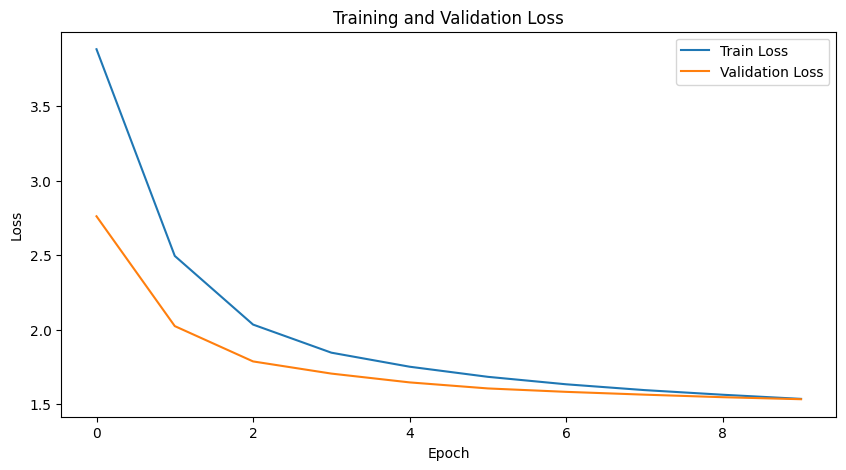

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [53]:
model.load_state_dict(torch.load('transformer-model-vlsp25.pt', map_location=DEVICE))
model.eval()
print("Model loaded")

Model loaded


In [54]:
bleu_score = calculate_bleu(test_data, src_vocab, trg_vocab, model, DEVICE)
print(f'\nBLEU score = {bleu_score*100:.2f}')

BLEU in 3000 test rows
--- Sentence: 0 ---
Src : knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in vientiane, lao
Trg : thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh viêng chăn, chdcnd lào, năm 2017
Pred: kiến thức , thực hành về sử dụng dịch vụ y tế công cộng của người có khám chữa bệnh bảo hiểm y tế và các yếu tố ảnh hưởng đến việc xử lý , công tác quản lý lao động
--- Sentence: 500 ---
Src : the results show that the overall quality of life score of diabetic patients is 62.10 ± 7.31, equivalent to the average quality of life of patients with diabetes.
Trg : kết quả cho thấy điểm chất lượng cuộc sống chung của người bệnh đái tháo đường là 62,10 ± 7,31, tương đương với chất lượng cuộc sống của người bệnh ở mức trung bình khá.
Pred: kết quả cho thấy điểm chất lượng cuộc sống chung của bệnh nhân đái thá

In [55]:
!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.4 MB/s eta 0:00:00


In [56]:
import sacrebleu
import json

def calculate_sacrebleu_bleu(data, src_vocab, trg_vocab, model, device):
    trgs = []
    pred_trgs = []

    print(f"BLEU in {len(data)} test rows")

    for i, example in enumerate(data):
        src = example['src']
        trg = example['trg']

        pred_tokens = translate_sentence(src, src_vocab, trg_vocab, model, device)        
        pred_str = " ".join(pred_tokens)
        
        if isinstance(trg, str):
            trg_str = trg
        else:
            trg_str = " ".join(trg)

        pred_trgs.append(pred_str)
        trgs.append(trg_str)

        if i % 500 == 0:
            print(f"--- Sentence: {i} ---")
            print(f"Src : {src}")
            print(f"Trg : {trg_str}")
            print(f"Pred: {pred_str}")

    bleu = sacrebleu.corpus_bleu(pred_trgs, [trgs])

    with open("vlsp_transformer_predictions.json", 'w', encoding='utf-8') as f:
        json.dump(pred_trgs, f, ensure_ascii=False, indent=4)
    
    print(f"SacreBLEU score: {bleu.score}")
    
    return bleu.score

In [57]:
bleu_score = calculate_sacrebleu_bleu(test_data, src_vocab, trg_vocab, model, DEVICE)

BLEU in 3000 test rows
--- Sentence: 0 ---
Src : knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in vientiane, lao
Trg : thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh viêng chăn, chdcnd lào, năm 2017
Pred: kiến thức , thực hành về sử dụng dịch vụ y tế công cộng của người có khám chữa bệnh bảo hiểm y tế và các yếu tố ảnh hưởng đến việc xử lý , công tác quản lý lao động
--- Sentence: 500 ---
Src : the results show that the overall quality of life score of diabetic patients is 62.10 ± 7.31, equivalent to the average quality of life of patients with diabetes.
Trg : kết quả cho thấy điểm chất lượng cuộc sống chung của người bệnh đái tháo đường là 62,10 ± 7,31, tương đương với chất lượng cuộc sống của người bệnh ở mức trung bình khá.
Pred: kết quả cho thấy điểm chất lượng cuộc sống chung của bệnh nhân đái thá

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


SacreBLEU score: 37.51640672356099
